![IonQ Logo](./logo.png)
# 2025 Quantum Information Competition - IonQ Challenge
## (June 29–July 1; Seoul, Korea 🇰🇷)
**VarQITE Demonstration (Supplementary Materials)**

## MaxCut with variational Quantum Imaginary Time Evolution (varQITE) method

In this notebook, we demonstrate how to leverage
[IonQ Forte][1]'s industry-leading capabilities to solve instances of the
[NP-hard][2] combinatorial optimization problem known as
[Maximum Cut (MaxCut)][3] using a
[novel variational Quantum Imaginary Time Evolution (varQITE)][4] algorithm
developed by IonQ in conjunction with researchers at Oak Ridge National Labs
(ORNL).

[1]: https://ionq.com/forte
[2]: https://en.wikipedia.org/wiki/NP-hardness
[3]: https://en.wikipedia.org/wiki/Maximum_cut
[4]: https://arxiv.org/pdf/2404.16135

## What's the problem, Doc? 
### MaxCut 101

The Maximum Cut (MaxCut) problem is a classic challenge in combinatorial optimization, frequently serving as a benchmark for new algorithms in scientific computing.

At its core, MaxCut is a graph problem. Given a graph $G=(V,E)$, where $V$ is the set of vertices and $E$ is the set of edges, the goal is to partition the vertices into two disjoint sets, $S$ and $T$. The objective is to maximize the number of edges that have one endpoint in $S$ and the other in $T$.

Imagine you have a network and you need to split it into two. The MaxCut problem asks: where do you draw the line to slice through the maximum possible number of connections?

This fundamental problem has wide-ranging applications, from designing optimal layouts for Very Large-Scale Integration (VLSI) circuits to identifying distinct communities within social networks and segmenting images in computer vision.

# 📦 Environment Setup
First, let's install the necessary dependencies.

In [1]:
pip install qiskit qiskit-aer networkx numpy pandas -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
## IonQ, Inc., Copyright (c) 2025,
# All rights reserved.
# Use in source and binary forms of this software, without modification,
# is permitted solely for the purpose of activities associated with the IonQ
# Challenge at 2025 Quantum Information Competition and only during the 
# June 29–July 1, 2025 duration of such event.

import matplotlib.pyplot as plt
from IPython import display

import networkx as nx
import numpy as np
import pandas as pd
import time

from typing import List
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator

# 🕸️ Graph Definition

To illustrate the problem, we will construct a simple graph utilizing the NetworkX library in Python. This initial definition serves as a basis for further exploration of more complex structures.

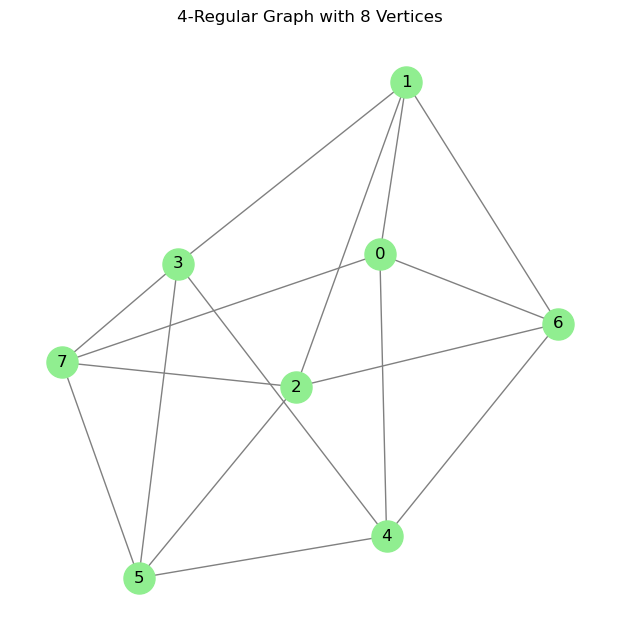

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import random

#-> 4-Regular Graph with 8 Vertices
def regular_graph_4_8():
    G = nx.random_regular_graph(d=4, n=8, seed=42)
    plt.figure(figsize=(6, 6))
    #pos = nx.circular_layout(G)
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', edge_color='gray', node_size=500)
    plt.title("4-Regular Graph with 8 Vertices")
    plt.show()
    return G

graph = regular_graph_4_8()

# ⚛️ Quantum Circuit Generator

We start by generating parameterized circuit based on a given graph.

In [4]:
# Visualization will be performed in the cells below;

def build_ansatz(graph: nx.Graph) -> QuantumCircuit:
    
    ansatz = QuantumCircuit(graph.number_of_nodes())
    ansatz.h(range(graph.number_of_nodes()))

    theta = ParameterVector(r"$\theta$", graph.number_of_edges())
    for t, (u, v) in zip(theta, graph.edges):
        ansatz.cx(u, v)
        ansatz.ry(t, v)
        ansatz.cx(u, v)

    return ansatz

## Understanding Parametrized Quantum Circuits (PQCs)
Parametrized Quantum Circuits (PQCs) have emerged as a leading strategy for harnessing the power of today's noisy, limited-scale quantum computers. By offering a practical approach to complex problems, they represent a significant step towards achieving quantum advantage in fields like machine learning, optimization, and chemistry.

A PQC is a type of quantum circuit that incorporates adjustable parameters within its gates. These parameters can be fine-tuned through classical optimization methods to solve specific problems.

Typically, a PQC is built in three stages:

1. State Preparation: Qubits are initialized to a standard state (e.g., ∣0⟩) and then placed into a superposition, using Hadamard gates.
2. Parameterized Operations: A sequence of gates, such as rotation gates (Rx, Ry, Rz) and entangling gates, are applied. The parameters of these gates are variables that can be adjusted to model the problem being solved.
3. Measurement: The qubits are measured to extract a classical outcome, which is then used to evaluate the circuit's performance.

PQCs are the core engine of Variational Quantum Algorithms (VQAs), which are hybrid systems that use a classical computer to optimize the parameters of the quantum circuit. Three of the most prominent VQAs are:

- Variational Quantum Eigensolver (VQE): Used to find the ground state energy of a molecule or material.
- Quantum Approximate Optimization Algorithm (QAOA): Designed to tackle combinatorial optimization problems.
- Variational Quantum Imaginary Time Evolution (varQITE): Solving the same problems as QAOA with some advantages.

By leveraging this hybrid approach, PQCs allow us to effectively utilize the capabilities of near-term quantum hardware.

For further reading on this topic:
https://arxiv.org/abs/2207.06850

## The Circuit Generator Function
The function below produces a Parametrized Quantum Circuit (PQC). You can see a visualization of a sample circuit it creates.

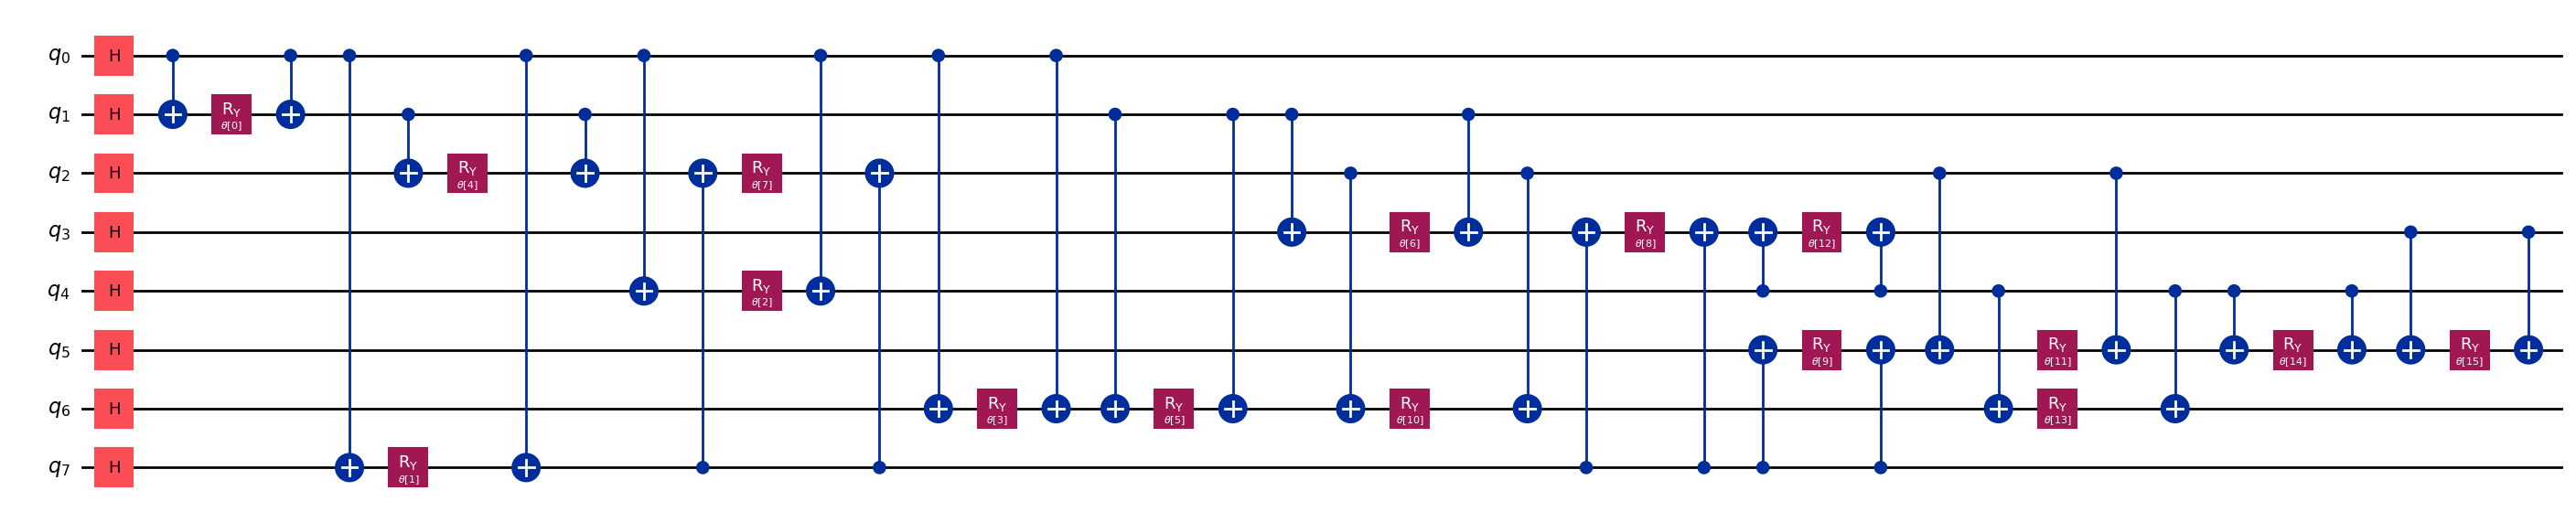

In [5]:
ansatz = build_ansatz(graph)
ansatz.draw("mpl", fold=-1)

# Building the MaxCut Hamiltonian

Formally, we write MaxCut as a [Quadratic Program (QP)][5] with binary
decision variables as follows. For each node $v \in V$, we let $x_v$ denote
a binary variable indicating whether $v$ belongs to $S$ or $T$. The objective
is to maximize the number of cut edges:
$$
    \text{maximize}_x\quad \sum_{(v, w) \in E} (x_v + x_w - 2 x_v x_w)
$$

Let's break this down. Notice that for each edge $e = (v, w)$ in the graph,
the quantity $(x_v + x_w - 2 x_v x_w)$ indicates whether $e$ is *cut* by the
partition represented by $x$; that is, the quantity $(x_v + x_w - 2 x_v x_w)$
is zero or one, and it equals one only if $v$ and $w$ lie on different sides of
the partition specified by $x$.

The code cell below obtains a symbolic representation of the maximization
objective corresponding to the graph above.

[5]: https://en.wikipedia.org/wiki/Quadratic_programming

In [6]:
 def build_maxcut_hamiltonian(graph: nx.Graph) -> SparsePauliOp:
    """
    Build the MaxCut Hamiltonian for the given graph H = (|E|/2)*I - (1/2)*Σ_{(i,j)∈E}(Z_i Z_j)
    """
    num_qubits = len(graph.nodes)
    edges = list(graph.edges())
    num_edges = len(edges)

    pauli_terms = ["I"*num_qubits] # start with identity
    coeffs = [-num_edges / 2]

    for (u, v) in edges: # for each edge, add -(1/2)*Z_i Z_j
        z_term = ["I"] * num_qubits
        z_term[u] = "Z"
        z_term[v] = "Z"
        pauli_terms.append("".join(z_term))
        coeffs.append(0.5)

    return SparsePauliOp.from_list(list(zip(pauli_terms, coeffs)))

Keep this function in its own cell. This will make it easier to adapt for different types of Max-Cut problems later.

In [7]:
ham = build_maxcut_hamiltonian(graph)
ham

SparsePauliOp(['IIIIIIII', 'ZZIIIIII', 'ZIIIIIIZ', 'ZIIIZIII', 'ZIIIIIZI', 'IZZIIIII', 'IZIIIIZI', 'IZIZIIII', 'IIZIIIIZ', 'IIIZIIIZ', 'IIIIIZIZ', 'IIZIIIZI', 'IIZIIZII', 'IIIZZIII', 'IIIIZIZI', 'IIIIZZII', 'IIIZIZII'],
              coeffs=[-8. +0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,
  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,
  0.5+0.j,  0.5+0.j,  0.5+0.j])

## Solving MaxCut as a Ground State Energy Problem

VarQITE can find the lowest energy state (or "ground state") of a quantum system described by a Hamiltonian. We can leverage this capability to solve MaxCut.

The strategy is to construct a specific Hamiltonian where each of its possible energy levels corresponds directly to a possible value of our MaxCut objective function. By doing this, finding the Hamiltonian's ground state is equivalent to finding the maximum cut.

This clever translation effectively converts our classical optimization problem into a quantum problem. We will then use our novel heuristic to find this ground state.

Given an objective function $C(x)$, with domain $x \in \{0, 1\}^n$, we'll
produce a Hamiltonian $H_C$ on $n$ qubits such that
$$
    H_C \ket{x} = C(x) \ket{x}.
$$
In the last equation, $\ket{x}$ denotes the $n$-qubit
[computational basis][10] state indexed by the bit-string $x \in \{0, 1\}$.
Thus the last equation says each of the $2^n$ computational basis states is an
eigenvector of $H_C$, and the eigenvalue corresponding to $\ket{x}$ is $C(x)$;
that is, $H_C$ is diagonal with respect to the computational basis, and its
energies are the values of the objective function $C$.

We'll obtain the Hamiltonian $H_C$ by replacing each $x_j$ in the expression of
$C(x)$ by the operator
$$
    \hat{X}_j \coloneqq \frac{1}{2}(I - Z_j),
$$
where $I$ denotes the identity operator on $n$ qubits and $Z_j$ denotes the
[Pauli-Z][11] operator acting on the $j$th qubit. Notice that $\hat{X}_j$ is
diagonal with respect to the computational basis, and its eigenvalues are zero
and one; in particular,
$$
    \hat{X}_j \ket{x} = x_j \ket{x}.
$$

## MaxCut Hamiltonian

When we apply the Ising map construction to the MaxCut objective
$$
    M(x) = \sum_{(v, w) \in E} (x_v + x_w - 2 x_v x_w)
$$
we obtain the Hamiltonian
$$
    H_M = \sum_{(v, w) \in E} (X_v + X_w - 2 X_v X_w) 
    = \frac{1}{2} \sum_{(v, w) \in E} \big(2 I - Z_v - Z_w - (I - Z_v)(I - Z_w)\big)
    = \frac{1}{2}|E| - \frac{1}{2} \sum_{(v, w) \in E} Z_v Z_w.
$$
In the last equation, $|E|$ denotes the number of edges in the graph.


[10]: https://en.wikipedia.org/wiki/Qubit#Standard_representation
[11]: https://en.wikipedia.org/wiki/Pauli_matrices

## Minimizing Energy with the varQITE Algorithm

Now that we have the MaxCut Hamiltonian, our goal is to find its lowest energy state. For this, we will use our [novel quantum-classical varQITE heuristic][1].

Like other Variational Quantum Algorithms (VQAs), [varQITE][1] works by iteratively updating parameters in a quantum circuit (an "ansatz") to minimize the energy of the Hamiltonian.

### A Key Difference: No Classical Optimizer

However, [varQITE][1] introduces a key innovation: it does not use a standard classical optimizer. Instead, it determines how to update the circuit's parameters by solving a system of linear Ordinary Differential Equations (ODEs) at each step.

This update rule is derived from the physics of [imaginary time evolution][4], which mathematically guarantees a path toward the ground state. The specific ODEs are formulated using the [Ehrenfest Theorem][3] and connect the circuit parameter gradients to the expectation values of certain operators. (For a detailed derivation, see Equation (5) in our [varQITE paper][1]).

### The aIgorithm loop

At each step of the algorithm, we will:

1. Execute a batch of quantum circuits on the current ansatz.
2. Post-process the measurement results.
3. Use these results to set up and solve the system of ODEs, which tells us how to update the parameters.

Below is simplified version of Quantum Imaginary Time Evolution (QITE). It uses a finite differences approach to estimate gradients, then performs gradient descent updates.

[1]: https://arxiv.org/abs/2404.16135
[2]: https://www.nature.com/articles/s42254-021-00348-9
[3]: https://en.wikipedia.org/wiki/Ehrenfest_theorem
[4]: https://en.wikipedia.org/wiki/Imaginary_time

In [8]:
class QITEvolver:
    """
    A class to evolve a parametrized quantum state under the action of an Ising
    Hamiltonian according to the variational Quantum Imaginary Time Evolution
    (QITE) principle described in IonQ's latest joint paper with ORNL.
    """
    def __init__(self, hamiltonian: SparsePauliOp, ansatz: QuantumCircuit):
        self.hamiltonian = hamiltonian
        self.ansatz = ansatz

        # Define some constants
        self.backend = AerSimulator()
        self.num_shots = 10000
        self.energies, self.param_vals, self.runtime = list(), list(), list()

    def evolve(self, num_steps: int, lr: float = 0.4, verbose: bool = True):
        """
        Evolve the variational quantum state encoded by ``self.ansatz`` under
        the action of ``self.hamiltonian`` according to varQITE.
        """
        curr_params = np.zeros(self.ansatz.num_parameters)
        for k in range(num_steps):
            # Get circuits and measure on backend
            iter_qc = self.get_iteration_circuits(curr_params)
            job = self.backend.run(iter_qc, shots=self.num_shots)
            q0 = time.time()
            measurements = job.result().get_counts()
            quantum_exec_time = time.time() - q0

            # Update parameters-- set up defining ODE and step forward
            Gmat, dvec, curr_energy = self.get_defining_ode(measurements)
            dcurr_params = np.linalg.lstsq(Gmat, dvec, rcond=1e-2)[0]
            curr_params += lr * dcurr_params

            # Progress checkpoint!
            if verbose:
                self.print_status(measurements)
            self.energies.append(curr_energy)
            self.param_vals.append(curr_params.copy())
            self.runtime.append(quantum_exec_time)

    def get_defining_ode(self, measurements: List[dict[str, int]]):
        """
        Construct the dynamics matrix and load vector defining the varQITE
        iteration.
        """
        # Load sampled bitstrings and corresponding frequencies into NumPy arrays
        dtype = np.dtype([("states", int, (self.ansatz.num_qubits,)), ("counts", "f")])
        measurements = [np.fromiter(map(lambda kv: (list(kv[0]), kv[1]), res.items()), dtype) for res in measurements]

        # Set up the dynamics matrix by computing the gradient of each Pauli word
        # with respect to each parameter in the ansatz using the parameter-shift rule
        pauli_terms = [SparsePauliOp(op) for op, _ in self.hamiltonian.label_iter() if set(op) != set("I")]
        Gmat = np.zeros((len(pauli_terms), self.ansatz.num_parameters))
        for i, pauli_word in enumerate(pauli_terms):
            for j, jth_pair in enumerate(zip(measurements[1::2], measurements[2::2])):
                for pm, pm_shift in enumerate(jth_pair):
                    Gmat[i, j] += (-1)**pm * expected_energy(pauli_word, pm_shift)
        
        # Set up the load vector
        curr_energy = expected_energy(self.hamiltonian, measurements[0])
        dvec = np.zeros(len(pauli_terms))
        for i, pauli_word in enumerate(pauli_terms):
            rhs_op_energies = get_ising_energies(pauli_word, measurements[0]["states"])
            rhs_op_energies *= get_ising_energies(self.hamiltonian, measurements[0]["states"]) - curr_energy
            dvec[i] = -np.dot(rhs_op_energies, measurements[0]["counts"]) / self.num_shots
        return Gmat, dvec, curr_energy

    def get_iteration_circuits(self, curr_params: np.array):
        """
        Get the bound circuits that need to be evaluated to step forward
        according to QITE.
        """
        # Use this circuit to estimate your Hamiltonian's expected value
        circuits = [self.ansatz.assign_parameters(curr_params)]

        # Use these circuits to compute gradients
        for k in np.arange(curr_params.shape[0]):
            for j in range(2):
                pm_shift = curr_params.copy()
                pm_shift[k] += (-1)**j * np.pi/2
                circuits += [self.ansatz.assign_parameters(pm_shift)]
        
        # Add measurement gates and return
        [qc.measure_all() for qc in circuits]
        return circuits
    
    def plot_convergence(self):
        """
        Plot the convergence of the expected value of ``self.hamiltonian`` with
        respect to the (imaginary) time steps.
        """
        plt.plot(self.energies)
        plt.xlabel("(Imaginary) Time step")
        plt.ylabel("Hamiltonian energy")
        plt.title("Convergence of the expected energy")

    def print_status(self, measurements):
        """
        Print summary statistics describing a QITE run.
        """
        stats = pd.DataFrame({
            "curr_energy": self.energies,
            "num_circuits": [len(measurements)] * len(self.energies),
            "quantum_exec_time": self.runtime 
        })
        stats.index.name = "step"
        display.clear_output(wait=True)
        display.display(stats)

Some utility functions:

In [9]:
def compute_cut_size(graph, bitstring):
    """
    Get the cut size of the partition of ``graph`` described by the given
    ``bitstring``.
    """
    cut_sz = 0
    for (u, v) in graph.edges:
        if bitstring[u] != bitstring[v]:
            cut_sz += 1
    return cut_sz

def get_ising_energies(
        operator: SparsePauliOp, 
        states: np.array):
    """
    Get the energies of the given Ising ``operator`` that correspond to the
    given ``states``.
    """
    # Unroll Hamiltonian data into NumPy arrays
    paulis = np.array([list(ops) for ops, _ in operator.label_iter()]) != "I"
    coeffs = operator.coeffs.real
    
    # Vectorized energies computation
    energies = (-1) ** (states @ paulis.T) @ coeffs
    return energies

def expected_energy(
        hamiltonian: SparsePauliOp,
        measurements: np.array):
    """
    Compute the expected energy of the given ``hamiltonian`` with respect to
    the observed ``measurement``.

    The latter is assumed to by a NumPy records array with fields ``states``
    --describing the observed bit-strings as an integer array-- and ``counts``,
    describing the corresponding observed frequency of each state.
    """
    energies = get_ising_energies(hamiltonian, measurements["states"])
    return np.dot(energies, measurements["counts"]) / measurements["counts"].sum()

def interpret_solution(graph, bitstring):
    """
    Visualize the given ``bitstring`` as a partition of the given ``graph``.
    """
    pos = nx.spring_layout(graph, seed=42)
    set_0 = [i for i, b in enumerate(bitstring) if b == '0']
    set_1 = [i for i, b in enumerate(bitstring) if b == '1']

    plt.figure(figsize=(4, 4))
    nx.draw_networkx_nodes(graph, pos=pos, nodelist=set_0, node_color='blue', node_size=700)
    nx.draw_networkx_nodes(graph, pos=pos, nodelist=set_1, node_color='red', node_size=700)

    cut_edges = []
    non_cut_edges = []
    for (u, v) in graph.edges:
        if bitstring[u] != bitstring[v]:
            cut_edges.append((u, v))
        else:
            non_cut_edges.append((u, v))

    nx.draw_networkx_edges(graph, pos=pos, edgelist=non_cut_edges, edge_color='gray', width=2)
    nx.draw_networkx_edges(graph, pos=pos, edgelist=cut_edges, edge_color='green', width=2, style='dashed')

    nx.draw_networkx_labels(graph, pos=pos, font_color='white', font_weight='bold')
    plt.axis('off')
    plt.show()

And finally the main execution loop:

,curr_energy,num_circuits,quantum_exec_time
step,,,
0,-8.0196,33,0.255144
1,-8.8152,33,0.219823
2,-8.9946,33,0.225520
3,-9.0146,33,0.232212
4,-9.4894,33,0.236893
5,-9.3096,33,0.244754
6,-9.7228,33,0.282611
7,-10.0022,33,0.293222
8,-10.3374,33,0.288906


CPU times: user 56.7 s, sys: 29.2 s, total: 1min 25s
Wall time: 10.4 s


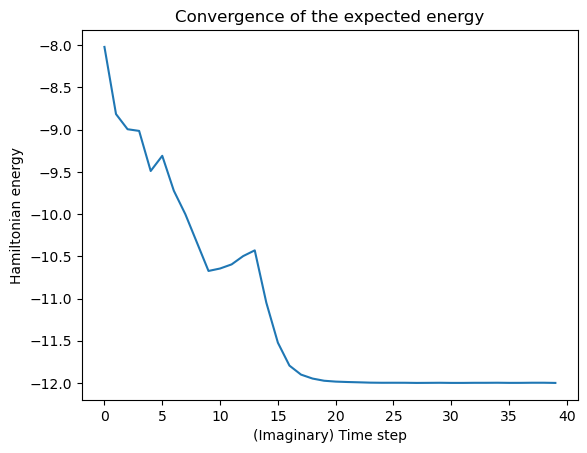

In [10]:
%%time

# Set up your QITEvolver and evolve! You can change number of steps (num_steps) and learning rate (lr)
qit_evolver = QITEvolver(ham, ansatz)
qit_evolver.evolve(num_steps=40, lr=0.5, verbose=True) # lr was 0.5

# Visualize your results!
qit_evolver.plot_convergence()

# Extracting and Interpreting the Solution

After running the vQITE algorithm, the final step is to determine the solution. We do this by repeatedly measuring (or "sampling") the final state of our quantum circuit. Each measurement collapses the quantum state into a classical bitstring (e.g., 011010).

The bitstring that appears most frequently in our samples is considered the best solution found by the algorithm.

In [11]:
from qiskit_aer import AerSimulator

shots = 100_000

# Sample your optimized quantum state using Aer
backend = AerSimulator()
optimized_state = ansatz.assign_parameters(qit_evolver.param_vals[-1])
optimized_state.measure_all()
counts = backend.run(optimized_state, shots=shots).result().get_counts()

# Find the sampled bitstring with the largest cut value
cut_vals = sorted(((bs, compute_cut_size(graph, bs)) for bs in counts), key=lambda t: t[1])
best_bs = cut_vals[-1][0]

# Now find the most likely MaxCut solution as sampled from your optimized state
# We'll leave this part up to you!!!
most_likely_soln = ""

print(counts)

{'10111110': 1, '00101111': 1, '01101011': 2, '01100001': 2, '01001111': 5, '01001101': 5, '10110100': 49156, '00001101': 2, '11110010': 1, '10110010': 1, '01000001': 1, '01001011': 49919, '01100011': 1, '10110110': 461, '10010100': 3, '01001001': 439}


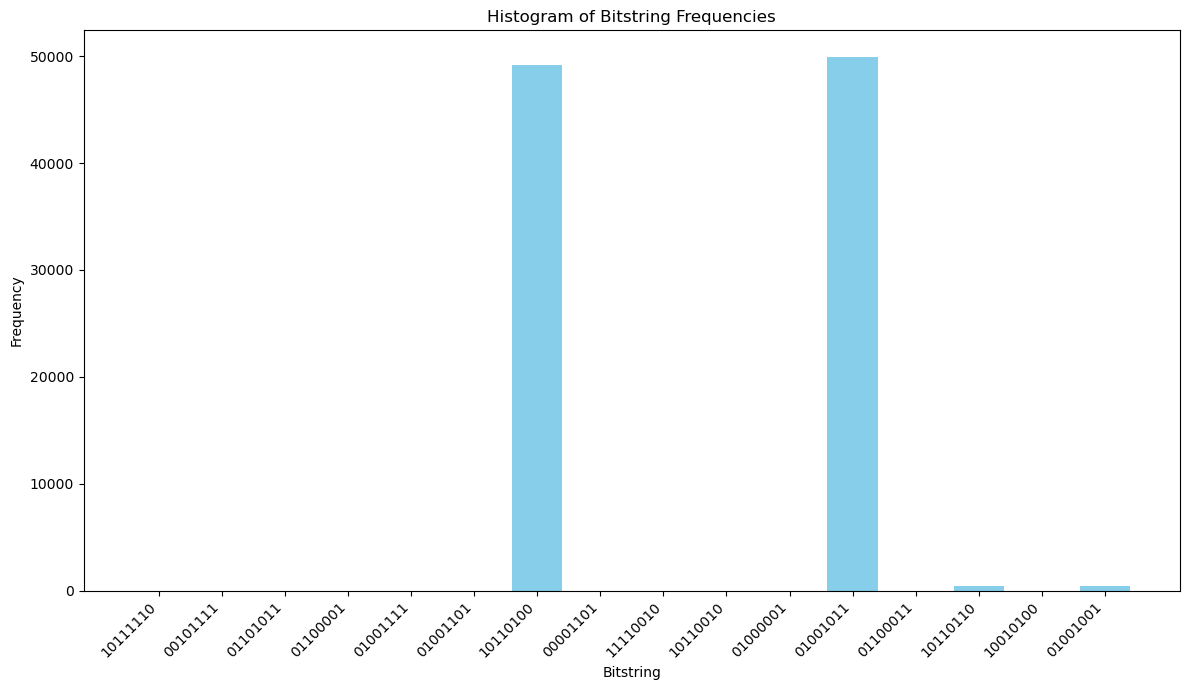

In [12]:
# Extract keys (bitstrings) and values (frequencies)
labels = list(counts.keys())
frequencies = list(counts.values())

# Create the plot
plt.figure(figsize=(12, 7))  # Adjust figure size for better readability
plt.bar(labels, frequencies, color='skyblue')

# Add titles and labels for clarity
plt.xlabel("Bitstring")
plt.ylabel("Frequency")
plt.title("Histogram of Bitstring Frequencies")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels to prevent overlap
plt.tight_layout()  # Adjust layout to make room for rotated labels

# Display the plot
plt.show()

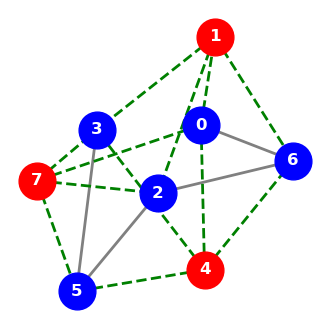

Cut value: 12
Graph with 8 nodes and 16 edges 01001001


In [13]:
interpret_solution(graph, best_bs)
print("Cut value: "+str(compute_cut_size(graph, best_bs)))
print(graph, best_bs)

# The END

Now is your turn to play with the code